In [11]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Device configuration

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Hyperparameters

In [13]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

## MNIST dataset

In [14]:
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

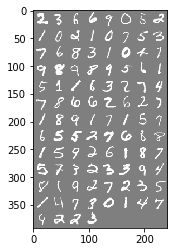

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
 

## Convolutional neural network (two convolutional layers)

In [16]:
# input image size: 28x28
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

## Model

In [17]:
model = ConvNet(num_classes).to(device)
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

## Loss and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

In [9]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.2167
Epoch [1/5], Step [200/600], Loss: 0.0920
Epoch [1/5], Step [300/600], Loss: 0.0769
Epoch [1/5], Step [400/600], Loss: 0.0892
Epoch [1/5], Step [500/600], Loss: 0.0387
Epoch [1/5], Step [600/600], Loss: 0.0491
Epoch [2/5], Step [100/600], Loss: 0.0734
Epoch [2/5], Step [200/600], Loss: 0.0470
Epoch [2/5], Step [300/600], Loss: 0.0599
Epoch [2/5], Step [400/600], Loss: 0.0623
Epoch [2/5], Step [500/600], Loss: 0.0256
Epoch [2/5], Step [600/600], Loss: 0.1485
Epoch [3/5], Step [100/600], Loss: 0.0068
Epoch [3/5], Step [200/600], Loss: 0.0489
Epoch [3/5], Step [300/600], Loss: 0.1182
Epoch [3/5], Step [400/600], Loss: 0.0401
Epoch [3/5], Step [500/600], Loss: 0.0377
Epoch [3/5], Step [600/600], Loss: 0.0204
Epoch [4/5], Step [100/600], Loss: 0.0329
Epoch [4/5], Step [200/600], Loss: 0.0040
Epoch [4/5], Step [300/600], Loss: 0.1278
Epoch [4/5], Step [400/600], Loss: 0.0286
Epoch [4/5], Step [500/600], Loss: 0.0435
Epoch [4/5], Step [600/600], Loss:

## Test the model

In [10]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.98 %


In [18]:
#torch.save(model.state_dict(), 'model.ckpt')
print("The state dic keys: \n\n", model.state_dict().keys())

The state dic keys: 

 odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer1.1.num_batches_tracked', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer2.1.num_batches_tracked', 'fc.weight', 'fc.bias'])
